## Overfitting & Regularization

<img src="../_img/overfitting.jpg" width="450px" align="left">

[Regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)) techniques in machine learning are used to prevent or reduce [overfitting](https://en.wikipedia.org/wiki/Overfitting) of a model to the training data. The fundamental idea is to simplify the model, making it less accurate on the training set but more accurate on unseen data. Essentially, the goal of regularization is to set a good balance between model complexity and generalization performance.

Some specific regularization techniques are [L1 regularization](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html#l1-regularization), [L2 regularization](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html#l2-regularization), [noise injection](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html#injecting-noise), [data augmentation](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html#data-augmentation), [early stopping](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html#early-stopping), [dropout](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html#dropout) and [ensembling](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html#ensembling). In this lecture we will discuss **L2 regularization** that can be seen as simple and well understood form of regularization.

## The SMS Spam Problem

The file [smsspam.txt](../_data/smsspam.txt) contains labeled SMS messages.
Label "ham" indicates normal messages, label "spam" indicates undesired  messages.
The goal is to build a classifier that estimates the label based on the text content of the SMS.
The error metric should be the average cross-entropy (aka `log_loss`).

<img src="../_img/sms_spam_problem.jpg" width="100px" align="left">

In [1]:
# Load the raw data into a DataFrame!
import pandas as pd
df = pd.read_csv("smsspam.txt", sep="\t", names=['label', 'message'])
df

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [3]:
# Distribution of labels.
df.groupby("label").size()

label
ham     4825
spam     747
dtype: int64

### How to represent SMS messages as numbers?

- Machine learning algorithms work with numbers, not words.
- One way to transform text into numbers is the [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) approach.
  + We assign an index to each word, based on a dictionary.
  + Each document is represented by a vector $x = [x_1, \dots, x_d]$ where $x_j$ denotes how many times the $j$-th word appears in the document.

<img src="../_img/sparse_matrix.png" width="350px" align="left">

**Exercise 1**: Compute the bag-of-words representation of the following example documents!

In [4]:
# Example documents.
documents = [
    'John likes to watch movies. Mary likes movies too.',
    'Mary also likes to watch football games.'
]

In [5]:
# Set of all words.
import string
def tokenize(doc):
    return [w.strip(string.punctuation) for w in doc.lower().split()]
words = set()
for doc in documents:
    for w in tokenize(doc):
        words.add(w)
words

{'also',
 'football',
 'games',
 'john',
 'likes',
 'mary',
 'movies',
 'to',
 'too',
 'watch'}

In [6]:
# Create dictionary of word indices.
word_to_idx = {w: i for i, w in enumerate(sorted(words))}
word_to_idx

{'also': 0,
 'football': 1,
 'games': 2,
 'john': 3,
 'likes': 4,
 'mary': 5,
 'movies': 6,
 'to': 7,
 'too': 8,
 'watch': 9}

In [7]:
# Build input matrix.
import numpy as np
X = np.zeros((len(documents), len(words)))
X

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [8]:
for i, doc in enumerate(documents):
    for w in tokenize(doc):
        j = word_to_idx[w]
        X[i, j] = 1
        
X

array([[0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 0., 1., 0., 1.]])

In [9]:
# Shorter solution with sklearn's CountVectorizer.
from sklearn.feature_extraction.text import CountVectorizer

X_sp = CountVectorizer(binary=True).fit_transform(documents) # fit(), then transform()
X_sp

<2x10 sparse matrix of type '<class 'numpy.int64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [10]:
X_sp.toarray()

array([[0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 0, 1, 0, 1]])

### [Sparse Matrices](https://en.wikipedia.org/wiki/Sparse_matrix) in Python

- A sparse matrix contains many zeros and only a low ratio of nenzero elements.
- The efficient method to store sparse matrices is to store only the nonzeros.
- The linear algebra operations operations (like matrix-times-vector) use different algorithms as in the dense case.
- NumPy supports dense matrices only.
- A library to work with sparse matrices is [scipy.sparse](https://docs.scipy.org/doc/scipy-1.8.0/html-scipyorg/reference/sparse.html). A more general library that supports multidimensional sparse arrays is [Sparse](https://sparse.pydata.org).

Some standard storage formats:
  + [coo_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html): A sparse matrix in COOrdinate list format.
  + [csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html): Compressed Sparse Row (CSR) matrix
  + [csc_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html): Compressed Sparse Column (CSC) matrix.
  
Typically, the COO format is the most convnient for creating/building matrices. However, in computations, the CSR or CSC format can be more efficient.

In [11]:
# Create an example COO matrix!
import scipy.sparse as sp
data = [1, 1, 1, 1, 1]
i    = [0, 0, 1, 2, 2] # row indices
j    = [0, 3, 1, 4, 5] # column indices

A = sp.coo_matrix((data, (i, j)))
A

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 5 stored elements in COOrdinate format>

In [12]:
# Number of nenzeros.
A.nnz

5

In [13]:
# Internal representation (.row, .col, .data).
A.row

array([0, 0, 1, 2, 2], dtype=int32)

In [14]:
A.col

array([0, 3, 1, 4, 5], dtype=int32)

In [15]:
A.data

array([1, 1, 1, 1, 1])

In [16]:
# Conversion to NumPy array.
A.toarray()

array([[1, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1]])

In [17]:
# Conversion to CSR format.
B = A.tocsr()
B

<3x6 sparse matrix of type '<class 'numpy.int64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [18]:
# Internal representation (.indices, .indptr, .data)
B.indices

array([0, 3, 1, 4, 5], dtype=int32)

In [19]:
B.indptr

array([0, 2, 3, 5], dtype=int32)

In [20]:
B.data

array([1, 1, 1, 1, 1])

In [21]:
# Selecting rows.
B[0]

<1x6 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [22]:
# try selecting rows from a COO matrix?
A[0]

TypeError: 'coo_matrix' object is not subscriptable

In [23]:
# Conversion to CSC format.
C = A.tocsc()

In [24]:
# try selecting rows from a CSC matrix?
C[:, 0]

<3x1 sparse matrix of type '<class 'numpy.int64'>'
	with 1 stored elements in Compressed Sparse Column format>

In [25]:
# What happens if we transpose a CSR matrix?
B.T

<6x3 sparse matrix of type '<class 'numpy.int64'>'
	with 5 stored elements in Compressed Sparse Column format>

### Back to the SMS Spam Problem

**Exercise 2**: Prepare the input matrix $X$ (sparse) and the target vector $y$ (dense)!

In [26]:
X = CountVectorizer(binary=True).fit_transform(df['message'])
X

<5572x8713 sparse matrix of type '<class 'numpy.int64'>'
	with 74169 stored elements in Compressed Sparse Row format>

In [27]:
y = (df['label'] == 'spam').values.astype('int64')
y

array([0, 0, 1, ..., 0, 0, 0])

**Exercise 3**: Measure the training and test log_loss error of logistic regression, using 5-fold cross-validation! (Scikit-learn's `LogisticRegression` and `LinearRegression` accept sparse matrices as the input matrix.)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

scores_tr = []
scores_te = []
cv = KFold (5, shuffle=True, random_state=42)
for tr, te in cv.split(X):
    cl = LogisticRegression()
    cl.fit(X[tr], y[tr])
    yhat = cl.predict_proba(X)[:, 1]
    scores_te.append(log_loss(y[te], yhat[te]))
    scores_tr.append(log_loss(y[tr], yhat[tr]))

scores_tr, scores_te

([0.020030998513910356,
  0.02026798586333316,
  0.018731273244436235,
  0.019306333644836884,
  0.01860439768051876],
 [0.04673015055948079,
  0.042830755193124764,
  0.060999083223150466,
  0.06704297424445832,
  0.06559486598950316])

In [30]:
# average training loss
np.mean(scores_tr)

0.01938819778940708

In [31]:
# average test loss
np.mean(scores_te)

0.0566395658419435

### [L2 Regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization)

<img src="../_img/regularization.jpg" width="250" align="left">

- L2 penalty term: $\frac{1}{2}\lambda \|w\|^2 = \frac{1}{2}\lambda w^Tw$, where $\lambda \geq 0$. (Other [norms](https://en.wikipedia.org/wiki/Norm_(mathematics)) could also be used instead of the L2 norm.)
- Regularized cross-entropy: $RCE(w) = CE(w) + \frac{1}{2}\lambda w^Tw$.
  + $\lambda$ is called the regularization coefficient. Larger $\lambda$ means stronger regularization.
  + An alternative formulation is $RCE^*(w) = C \cdot CE(w) + \frac{1}{2} w^Tw$.
- Gradient vector: $\frac{d}{dw} RCE(w) = \frac{d}{dw} CE(w) + \lambda w$.
- Hessian matrix: $\left(\frac{d}{dw}\right)^2 RCE(w) = \left(\frac{d}{dw}\right)^2 CE(w) + \lambda I$.

**Exercise 4**: Plot the training and test error of logistic regression, as the function of the regularization coefficient $\lambda$! The relation between $\lambda$ and scikit-learn's $C$ parameter is $C = 1 / \lambda$.

In [43]:
# Model evaluation function
def evaluat(cl, X, y):
    scores_tr = []
    scores_te = []
    cv = KFold (5, shuffle=True, random_state=42)
    for tr, te in cv.split(X):
        cl.fit(X[tr], y[tr])
        yhat = cl.predict_proba(X)[:, 1]
        scores_te.append(log_loss(y[te], yhat[te]))
        scores_tr.append(log_loss(y[tr], yhat[tr]))
    
    return {
        'score_tr': np.mean(scores_tr), 
        'score_te': np.mean(scores_te)
    }

In [44]:
evaluat(LogisticRegression(), X, y)

{'score_tr': 0.01938819778940708, 'score_te': 0.0566395658419435}

In [48]:
data = []

for lambd in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100]:
    print(lambd)
    cl = LogisticRegression(C=1 / lambd)
    res = evaluat(cl, X, y)
    res['lambda'] = lambd
    data.append(res)

1e-06
1e-05
0.0001
0.001
0.01
0.1
1
10
100


In [49]:
df = pd.DataFrame(data)
df

,score_tr,score_te,lambda
0,1.986250e-07,0.148967,0.000001
1,1.218466e-06,0.116675,0.000010
2,9.898300e-06,0.094971,0.000100
3,7.655900e-05,0.078730,0.001000
4,5.521189e-04,0.064444,0.010000
5,3.613759e-03,0.054485,0.100000
6,1.938820e-02,0.056640,1.000000
7,7.011759e-02,0.088672,10.000000
8,1.784698e-01,0.185667,100.000000


<AxesSubplot: xlabel='lambda'>

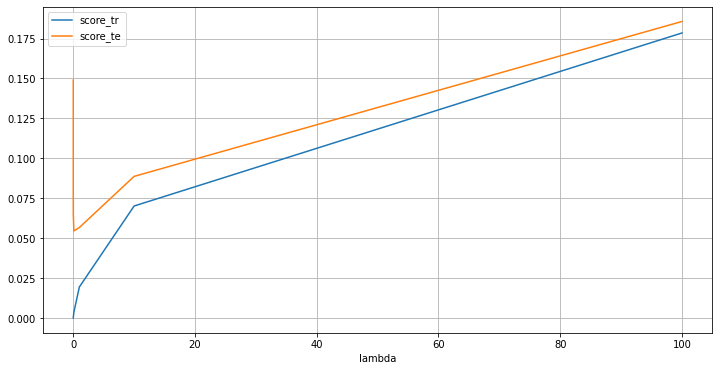

In [50]:
df.set_index('lambda').plot(figsize=(12, 6), grid=True)

<AxesSubplot: xlabel='lambda'>

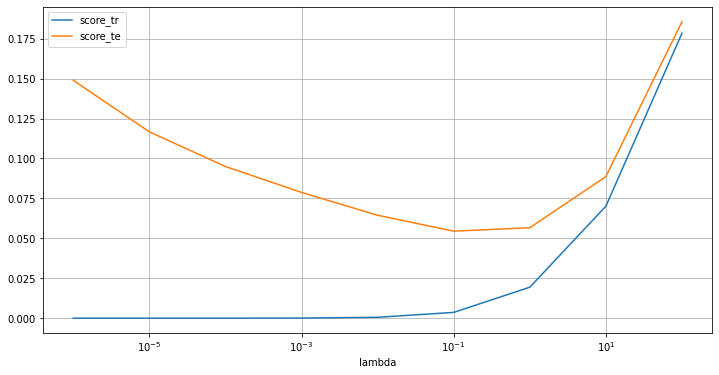

In [51]:
df.set_index('lambda').plot(figsize=(12, 6), grid=True, logx=True)

In [55]:
# optimal lambda value
df['score_te'].idxmin()
df

,score_tr,score_te,lambda
0,1.986250e-07,0.148967,0.000001
1,1.218466e-06,0.116675,0.000010
2,9.898300e-06,0.094971,0.000100
3,7.655900e-05,0.078730,0.001000
4,5.521189e-04,0.064444,0.010000
5,3.613759e-03,0.054485,0.100000
6,1.938820e-02,0.056640,1.000000
7,7.011759e-02,0.088672,10.000000
8,1.784698e-01,0.185667,100.000000


<AxesSubplot: xlabel='lambda'>

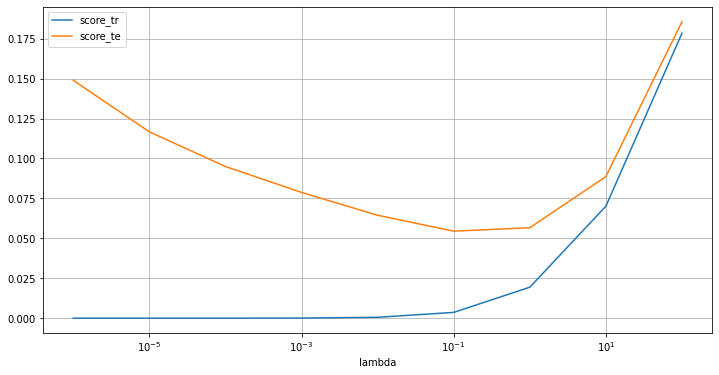

In [58]:
df_res = pd.DataFrame(data).set_index('lambda')
df_res.plot(figsize=(12, 6), grid=True, logx=True)

In [59]:
# optimal lambda value
df_res['score_te'].idxmin()

0.1

## [Ridge Regression](https://en.wikipedia.org/wiki/Ridge_regression)

- Ridge regression is the L2 regularized variant of linear regression.


- The error function is $RSSE(w) = \left[\sum_{i=1}^n (\hat{y}_i - y_i)^2\right] + \lambda \left[\frac{1}{2} w^T w\right]$,<br>where $\lambda \geq 0$ is the regularization coefficient.


- Linear regression is contained as a special case, with $\lambda$ set to zero.

**Exercise 5**: Train ridge regression models on the Boston Housing data set that predict the `MEDV` column. The error metric should be RMSE. Plot the training and test error of ridge regression, as the function of the regularization coefficient $\alpha$!

In [62]:
# Load the Boston Housing data set.
columns = []
for l in open('housing_names.txt'):
    if l[:4] == '    ' and l[4].isdigit():
        columns.append(l.split()[1])
df = pd.read_csv('housing_data.txt', sep='\t', names=columns)        

In [63]:
X = df[df.columns[:-1]].values # input matrix
y = df['MEDV'].values          # target vector

In [64]:
X.shape

(506, 12)

In [65]:
y.shape

(506,)

In [66]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [84]:
# Model evaluation function.
def evaluate(re, X, y):    
    cv = KFold(7, shuffle=True, random_state=42)
    scores_tr = []
    scores_te = []
    for tr, te in cv.split(X):
        re.fit(X[tr], y[tr])
        yhat = re.predict(X)
        scores_tr.append(mean_squared_error(y[tr], yhat[tr])**0.5)
        scores_te.append(mean_squared_error(y[te], yhat[te])**0.5)

    return {
        'score_tr': np.mean(scores_tr),
        'score_te': np.mean(scores_te)
    }

In [86]:
# Trying different alpha values.
data = []
for alpha in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100]:
    print(alpha)
    re = Ridge(alpha=alpha)
    res = evaluate(re, X, y)
    res['alpha'] = alpha
    data.append(res)

1e-06
1e-05
0.0001
0.001
0.01
0.1
1
10
100


<AxesSubplot: xlabel='alpha'>

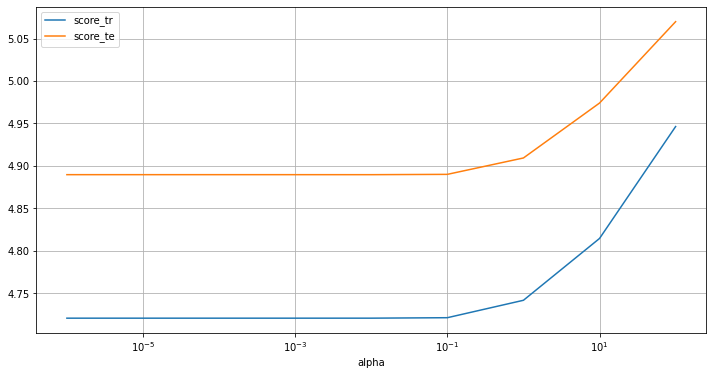

In [87]:
df_res = pd.DataFrame(data).set_index('alpha')
df_res.plot(figsize=(12, 6), grid=True, logx=True)